In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
df=pd.read_excel("covid_World_updated.xlsx")
df.date=pd.to_datetime(df.date,infer_datetime_format=True)
#United States,Brazil,World,India
location_name="World"
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


### Creating Data Frame with Total Cases lags

In [11]:
from fbprophet import Prophet

In [12]:
def accuracy(realSales_series, prediction_series):

    assert isinstance(realSales_series, pd.Series), 'Real Sales should be in pandas Series format'
    assert isinstance(prediction_series, pd.Series), 'Prediction should be in pandas Series format'
#     prediction_series=np.max(0,prediction_series)
    acc =round((1 - abs(prediction_series - realSales_series)/prediction_series) * 100,2)
    acc.loc[(realSales_series == 0) & (prediction_series != 0)] = 0
    acc.loc[(realSales_series == 0) & (prediction_series == 0)] = np.nan
    #acc.loc[acc > 95] = 100
    acc.loc[acc < 0] = 0
    acc.dropna()
    return acc

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [14]:
def forecasting(df_out,regressor,table,graph):
    
    df_out1=pd.DataFrame(columns=["ds","y"]) 
    
        
    df_out1['y']=df_out['Deaths']
    df_out1['ds']=df_out.index
    
    if regressor=="Confirmed":
        df_out1['ConLag14']=df_out['ConLag14']
#     elif regressor=="Cured":
#         df_out1['CurLag5']=df_out['CurLag5']
#     else:
#         df_out1['ConLag5']=df_out['ConLag5']
#         df_out1['CurLag5']=df_out['CurLag5']
        
        
    df_out1.reset_index(inplace=True,drop=True)
    
    #print(df_out1)
    
        
    model=Prophet(daily_seasonality=True,yearly_seasonality=False)
    
    if regressor=="Confirmed":
        model.add_regressor('ConLag14')
#     elif regressor=="Cured":
#         model.add_regressor('CurLag5')
#     else:
#         model.add_regressor('ConLag5')
#         model.add_regressor('CurLag5')
        
    #print(df_out)    
    model.fit(df_out1)
    
    future = model.make_future_dataframe(periods=14)
    
    if regressor=="Confirmed":
        conlag=list(df_out1['ConLag14'])
        for i in range(14,0,-1):
            conlag.append(list(df_location['total_cases'])[-i])
        #print(conlag)
            
        future['ConLag14']=list(conlag)
        #print(future.tail(14))
        #print(future)
#     elif regressor=="Cured":
#         curlag=list(df_out1['CurLag5'])
#         #curlag.append(list(df_State['Cured'])[-1])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])

#         future['CurLag5']=list(curlag)
#     else:
#         conlag=list(df_out1['ConLag5'])
#         for i in range(5,0,-1):
#             conlag.append(list(df_State['Confirmed'])[-i])
#         #conlag.append(list(df_State['Confirmed'])[-1])
#         curlag=list(df_out1['CurLag5'])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])
#         #curlag.append(list(df_State['Cured'])[-1])
#         future['ConLag5']=list(conlag)
#         future['CurLag5']=list(curlag)
#     #print(future)
    
    forecast=model.predict(future)
    if table=="Yes":
        print("Forecasted Table for number of Deaths for location: "+location_name+"\n")
        Forecast=pd.DataFrame()
        Forecast['Day']=forecast['ds']
        Forecast['Forecasted_Death']=[int(x) for x in list(forecast['yhat'])]
        Forecast['Lower Limit']=[int(x) for x in list(forecast['yhat_lower'])]
        Forecast['Upper Limit']=[int(x) for x in list(forecast['yhat_upper'])]
        Forecast.set_index('Day',inplace=True)
        print(Forecast.tail(14))
    return list(Forecast['Forecasted_Death'])[-1]

In [15]:
i=121
j=i-14
table="Yes"
graph="Yes"
regressor="Confirmed"
pred14=[]
while j>=0:
    df.index = pd.DatetimeIndex(df.date)
    df_location=df[df['location']==location_name]
    df_location=df_location[:-i]
    df_location['date']=df_location.index
    df_location.reset_index(inplace = True, drop = True)
    df_out={'Date': df_location.date.to_list(),
             'Deaths':df_location.total_deaths.to_list(),
            'ConLag14':df_location.total_cases.shift(14).to_list(),
           }
    df_out=pd.DataFrame(df_out)
    df_out.columns
    df_out=df_out.dropna()
    df_out.set_index('Date',inplace=True)
    for cols in df_out.columns:
        if cols=="Date":
            continue
        else:
            df_out[cols]=df_out[cols].astype(int)
            
    print('df_out')
    print(df_out)
            
    pred14.append(forecasting(df_out,regressor,table,graph))
    i=i-1
    j=j-1

df_out
            Deaths  ConLag14
Date                        
2020-01-14       1        27
2020-01-15       2        27
2020-01-16       2        27
2020-01-17       2        44
2020-01-18       2        44
...            ...       ...
2020-05-27  349594   4213814
2020-05-28  354737   4300071
2020-05-29  359379   4396614
2020-05-30  364032   4493833
2020-05-31  368044   4586768

[139 rows x 2 columns]


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-01            375107       373574       376491
2020-06-02            379293       377846       380748
2020-06-03            384271       382742       385953
2020-06-04            389425       387697       391145
2020-06-05            394525       392661       396518
2020-06-06            399506       397306       401735
2020-06-07            404075       401470       406666
2020-06-08            408163       404927       411409
2020-06-09            412390       408820       415738
2020-06-10            417339       412881       421459
2020-06-11            422485       417486       427420
2020-06-12            427760       421666       433259
2020-06-13            433007       426333       439468
2020-06-14            438035       430507       445181
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-08            401550       400348       402716
2020-06-09            405307       404240       406444
2020-06-10            409876       408590       411176
2020-06-11            414456       413022       415932
2020-06-12            418983       417226       420898
2020-06-13            423502       421453       425779
2020-06-14            427591       425221       430298
2020-06-15            431070       428252       434467
2020-06-16            434821       431329       438827
2020-06-17            439379       435101       444329
2020-06-18            443947       439123       450076
2020-06-19            448469       442425       455343
2020-06-20            452982       446204       460367
2020-06-21            457072       449634       466002
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-15            432196       431336       432993
2020-06-16            436115       435245       436985
2020-06-17            440918       439959       441896
2020-06-18            446020       444828       447140
2020-06-19            451064       449687       452412
2020-06-20            456056       454464       457794
2020-06-21            460609       458432       462956
2020-06-22            464386       461641       467300
2020-06-23            468384       465036       471887
2020-06-24            473379       469408       477494
2020-06-25            478621       474234       483927
2020-06-26            483803       478317       489478
2020-06-27            488966       482609       495751
2020-06-28            493629       486285       501165
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-22            465675       464869       466445
2020-06-23            469693       468865       470573
2020-06-24            475027       474084       475947
2020-06-25            480561       479470       481596
2020-06-26            486056       484688       487414
2020-06-27            491584       489985       493451
2020-06-28            496461       494316       498693
2020-06-29            500549       498100       503685
2020-06-30            504875       501560       508695
2020-07-01            510598       506661       514964
2020-07-02            517135       512542       522268
2020-07-03            522685       517265       528488
2020-07-04            529066       523113       535872
2020-07-05            534586       527804       542217
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-06-29            499958       499237       500733
2020-06-30            504182       503386       504985
2020-07-01            509795       508917       510721
2020-07-02            516233       515149       517286
2020-07-03            521756       520379       523132
2020-07-04            528005       526280       529858
2020-07-05            533472       531032       535643
2020-07-06            537767       534697       540573
2020-07-07            542347       538586       545876
2020-07-08            548467       543736       552536
2020-07-09            554863       549642       559541
2020-07-10            561297       554901       566893
2020-07-11            567735       560470       574028
2020-07-12            573694       565656       580750
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-06            532944       531987       533841
2020-07-07            537223       536341       538175
2020-07-08            542800       541743       543911
2020-07-09            548554       547366       549746
2020-07-10            554341       552958       555617
2020-07-11            560001       558191       561943
2020-07-12            565230       563024       567504
2020-07-13            569677       566990       572268
2020-07-14            574265       570896       577354
2020-07-15            580205       575952       584078
2020-07-16            586288       581280       590745
2020-07-17            592460       586949       597684
2020-07-18            598337       592038       604366
2020-07-19            603683       596448       610803
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-13            565150       564213       566054
2020-07-14            569427       568474       570393
2020-07-15            574918       573865       575863
2020-07-16            580391       579190       581597
2020-07-17            585949       584537       587343
2020-07-18            591200       589352       593025
2020-07-19            595961       593583       598274
2020-07-20            600036       597319       603042
2020-07-21            604398       600862       607857
2020-07-22            609967       605609       613920
2020-07-23            615519       610321       620393
2020-07-24            621163       615382       626862
2020-07-25            626549       619666       633289
2020-07-26            631452       623922       639114
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-20            600114       599244       600973
2020-07-21            604445       603558       605341
2020-07-22            609939       608933       610933
2020-07-23            615451       614194       616626
2020-07-24            621011       619563       622490
2020-07-25            626447       624503       628339
2020-07-26            631405       629182       633685
2020-07-27            635507       632447       638656
2020-07-28            639904       636299       643625
2020-07-29            645474       641428       649910
2020-07-30            651060       646095       656434
2020-07-31            656754       651024       662850
2020-08-01            662267       655993       669192
2020-08-02            667281       659812       675240
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-07-27            641618       640384       642861
2020-07-28            646291       645046       647467
2020-07-29            652440       651111       653813
2020-07-30            658704       657345       660069
2020-07-31            665371       663731       667092
2020-08-01            671665       670085       673572
2020-08-02            677214       675184       679498
2020-08-03            681815       679272       684769
2020-08-04            686634       683426       690188
2020-08-05            692976       688954       697120
2020-08-06            699837       695067       704760
2020-08-07            706766       701036       712466
2020-08-08            713487       707082       719957
2020-08-09            719386       712017       726599
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-03            685907       684925       686841
2020-08-04            691076       690056       692211
2020-08-05            697778       696658       698927
2020-08-06            705140       703824       706469
2020-08-07            712507       710755       714147
2020-08-08            719745       717717       721561
2020-08-09            726208       723767       728361
2020-08-10            731655       728494       734452
2020-08-11            737023       733408       740163
2020-08-12            743796       739336       747682
2020-08-13            751454       746498       756120
2020-08-14            759073       753172       764208
2020-08-15            766225       759517       772474
2020-08-16            772834       765392       779753
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-10            729065       727946       730151
2020-08-11            734199       733038       735249
2020-08-12            740914       739769       742122
2020-08-13            748530       747246       749975
2020-08-14            756157       754698       757611
2020-08-15            763124       761402       764725
2020-08-16            769494       767411       771373
2020-08-17            774607       771869       776982
2020-08-18            779618       776683       782714
2020-08-19            786536       783005       790142
2020-08-20            793802       789791       798165
2020-08-21            801351       796459       806142
2020-08-22            808264       802850       814072
2020-08-23            814650       808810       821260
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-17            771541       770466       772640
2020-08-18            776477       775332       777580
2020-08-19            783180       781911       784334
2020-08-20            790150       788860       791421
2020-08-21            797439       796014       798757
2020-08-22            804195       802381       805797
2020-08-23            810501       808266       812402
2020-08-24            815540       812750       817989
2020-08-25            820691       817356       823520
2020-08-26            827476       823635       830938
2020-08-27            834613       830109       838889
2020-08-28            841912       836531       846665
2020-08-29            848853       842992       854609
2020-08-30            855030       848409       862271
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-24            812493       811421       813608
2020-08-25            817648       816473       818833
2020-08-26            824324       823091       825477
2020-08-27            831155       829762       832544
2020-08-28            838141       836572       839699
2020-08-29            844761       843035       846579
2020-08-30            850690       848323       852815
2020-08-31            855738       853089       858288
2020-09-01            860667       857331       863850
2020-09-02            867281       863450       871256
2020-09-03            874036       869689       878699
2020-09-04            880920       875768       886311
2020-09-05            887193       881314       893679
2020-09-06            893191       886517       900158
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-08-31            850833       849684       852156
2020-09-01            855935       854768       857101
2020-09-02            862354       861012       863637
2020-09-03            868811       867457       870135
2020-09-04            875463       873942       877143
2020-09-05            881578       879804       883398
2020-09-06            887264       885214       889105
2020-09-07            892201       889696       894580
2020-09-08            897321       894271       899855
2020-09-09            903740       900043       907292
2020-09-10            910191       905985       914525
2020-09-11            916852       911878       921488
2020-09-12            922997       917612       928679
2020-09-13            928685       922402       935200
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-07            888930       887603       890271
2020-09-08            893971       892541       895390
2020-09-09            900225       898729       901769
2020-09-10            906477       904882       908122
2020-09-11            912898       911193       914579
2020-09-12            918966       916975       921002
2020-09-13            924608       922250       926719
2020-09-14            929405       926820       931975
2020-09-15            934285       930984       937414
2020-09-16            940469       936690       944084
2020-09-17            946688       942002       951182
2020-09-18            953133       947840       958007
2020-09-19            959113       953325       964866
2020-09-20            964699       957542       971216
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-14            928477       926963       930042
2020-09-15            933481       932108       935144
2020-09-16            939678       937978       941346
2020-09-17            945816       943971       947682
2020-09-18            952151       950118       954149
2020-09-19            958119       955894       960377
2020-09-20            963662       961105       966240
2020-09-21            968632       965829       971591
2020-09-22            973726       970171       977400
2020-09-23            979982       976288       984272
2020-09-24            986109       981718       991182
2020-09-25            992379       986807       998216
2020-09-26            998317       992264      1004877
2020-09-27           1003842       996941      1011440
df_out
            Deaths  ConLag14
Date                     

In [27]:
df_output=pd.DataFrame()
mape=[]
df_location=df[df['location']==location_name]
real=list(df_location.total_deaths[-len(pred14):])
for i in range(len(real)):
    mape.append(mean_absolute_percentage_error(real[i],pred14[i]))
score=accuracy(pd.Series(real),pd.Series(pred14))
df_output['Date']=list(df[df['location']==location_name].date[-len(pred14):])
df_output['Real']=real
df_output['Pred']=pred14
df_output['Accuracy']=score
df_output['Error%(MAPE)']=mape 
#df_output.set_index(df_output.Date,inplace=True,drop=True)

In [30]:
with pd.option_context('display.max_columns', 200,'display.max_rows', 200):
    display(df_output)

,Date,Real,Pred,Accuracy,Error%(MAPE)
0,2020-06-14,427915.0,438035,97.69,2.364956
1,2020-06-15,431072.0,438026,98.41,1.613188
2,2020-06-16,434450.0,433310,99.74,0.262401
3,2020-06-17,441169.0,437223,99.10,0.894442
4,2020-06-18,446269.0,440919,98.79,1.198829
5,2020-06-19,452544.0,444421,98.17,1.794964
6,2020-06-20,457575.0,454072,99.23,0.765558
7,2020-06-21,461691.0,457072,98.99,1.000453
8,2020-06-22,465657.0,461234,99.04,0.949841
9,2020-06-23,469053.0,464099,98.93,1.056171


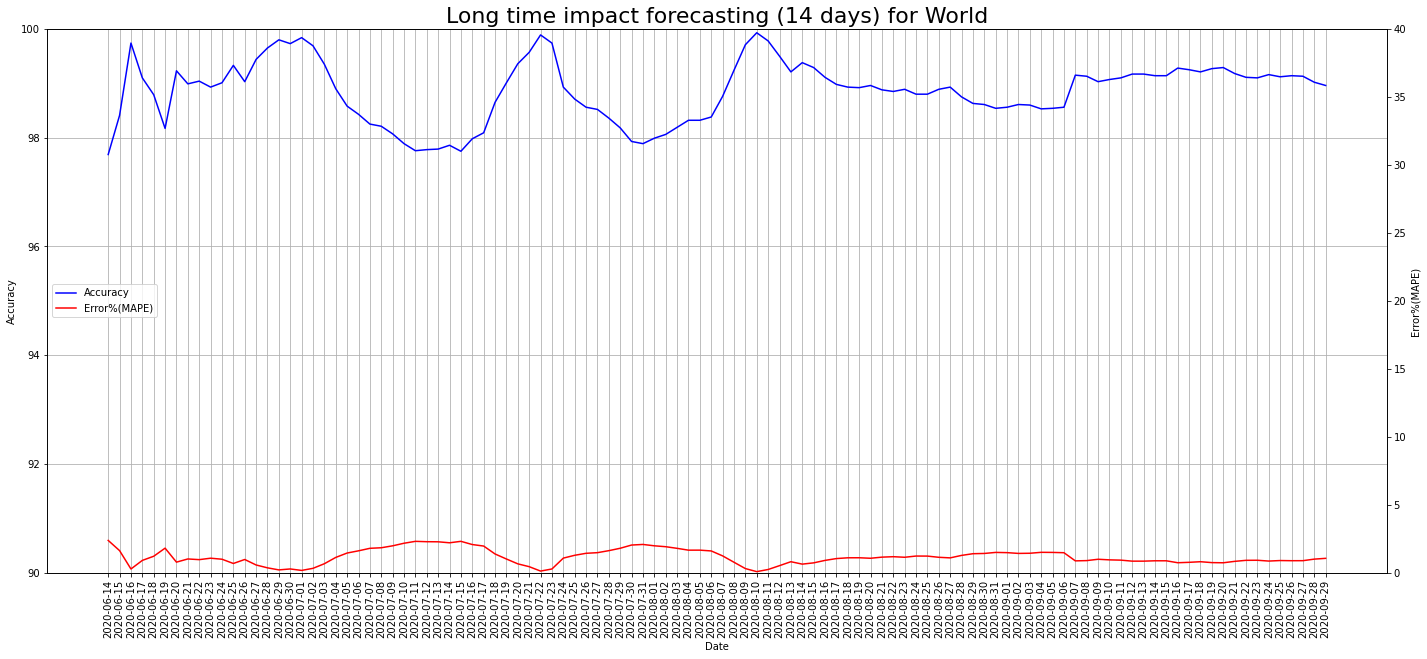

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = [24, 10]
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

title="Long time impact forecasting (14 days) for "+location_name
plt.title(title,fontsize= 22)
ax1.grid()

ax1.set_ylim(90,100)
accuracy=ax1.plot(df_output.Date,df_output['Accuracy'],color="blue",label='Accuracy')

error=ax2.plot(df_output.Date,df_output['Error%(MAPE)'],color="red",label='Error%(MAPE)')

ax2.set_ylim([0, 40])
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_xticks(df_output['Date'])

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Date')
ax2.set_ylabel('Error%(MAPE)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=6)
plt.show()